# Open data

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/home/m3learning/Northwestern/Gaussian_Sampler/')
sys.path.append('/home/m3learning/Northwestern/M3Learning-Util/src')
sys.path.append('/home/m3learning/Northwestern/AutoPhysLearn/src')

datapath = '/home/m3learning/Northwestern/Northwestern_link/Morlet/'

In [2]:
import numpy as np
import pickle
import math
import matplotlib.pyplot as plt

file = 'sa-1-5a-1M-old-multiplex-scan-autorange-savegain.pickle'

# load pickle
with open(datapath + file, 'rb') as f:
    data = pickle.load(f)

/tmp/ipykernel_3864168/4076214450.py:10: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  data = pickle.load(f)


In [8]:
# data contains all of the data from an acoustic scan experiment as a dict of dicts
# The primary key is an int representing the data at a coordinate in the scan
# Each value is a dict with the associated data as well as a few string keys that contain metadata
# Example: battery_scan_01.pickle -> unpickle to dict
# { voltage_echo_forward : np.array([...]),
#   time : np.array([...]),
# { 0 :   coordinate : (x, y),
#         primaryAxis : 'X',
#         maxMinusMin : 5,...}
#  1 : { same keys : new data }
# ...
# 'fileName' : name of file to load and save the pickle
# All experimental parameters are saved as a sub-dict with key 'parameters'
# 'parameters' :{time_started : x, delay : y,...}
# }


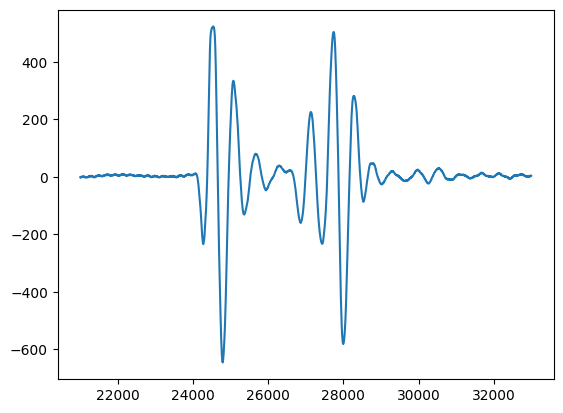

In [9]:
# The data we want to decompose is saved under the following keys at each coordinate:
xkey = 'time'
ykeys = ['echo_forward_filtered', 'echo_reverse_filtered', 'transmission_forward_filtered', 'transmission_reverse_filtered']

# The xKey is the x-axis for each plot (time in ns). The yKeys are the measurements at each point in four different collection
# modes. The data has been put through a high-pass filter and baseline corrected
# Note that the values for time are the same for all scans at all points in a given file, so you can use the same x-axis
# array for all data
# As an example, plotting the data to fit at collection index 530 could be done by
t = data[530]['time']
echo_forward = data[530]['echo_forward_filtered']
plt.plot(t, echo_forward)
plt.show()


In [10]:
len(t)

6000

In [11]:
integer_keys = [key for key in data.keys() if isinstance(key, int)]

In [12]:
cube = [data[i]['echo_forward_filtered'] for i in integer_keys]
cube = np.array(cube)

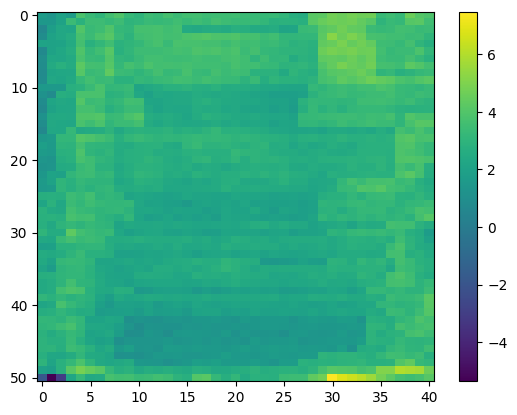

In [13]:
plt.imshow(cube.mean(-1).reshape(51,-1), aspect='auto')
plt.colorbar()

## function definitions

In [3]:


# create sin-like morlet by multiplying gaussian and sine function
# inputs the time array and the fitting parameters: amp and t0
# outputs the value of the Morlet at all of the input time values
def morlet(times, amp, t0):
    # Constants derived from fitting acoustic pulses in water
    sigma = 339  # width of gaussian window
    freq = 0.0033  # central frequency of wavelet
    angularFreq = 2 * np.pi * freq  # convert frequency to angular units
    return amp * np.exp((-1 * (times - t0) ** 2) / (2 * sigma ** 2)) * np.sin(angularFreq * (times - t0))

# Not sure if this is helpful, but here's a function to iterate through the data dict and grab all of the y-data
# that we want to decompose into a big matrix
def consolidateDataIntoMatrix(dataDict, keys=['echo_forward_filtered', 'echo_reverse_filtered', 'transmission_forward_filtered', 'transmission_reverse_filtered']):
    # determine amount of data arrays. 4 arrays per collection index. Subtract 2 because 2 keys do not contain data
    arrayLen = len(dataDict[0]['time'])
    numberOfKeys = len(keys)
    numberOfArrays = numberOfKeys * (len(dataDict.keys()) - 2)
    dataMatrix = np.zeros((numberOfArrays, arrayLen))
    
    # build matrix by iterating through keys
    for i in range(numberOfArrays):
        key = keys[(i % numberOfKeys)]
        collectionIndex = math.floor(i / numberOfKeys)
        dataMatrix[i, :] = dataDict[collectionIndex][key]
           
    return dataMatrix


In [4]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
keys=['echo_forward_filtered', 'echo_reverse_filtered', 'transmission_forward_filtered', 'transmission_reverse_filtered']
dataset = np.array([[data[i][key] for key in keys] for i in range(len(data)-2)])
dataset.shape

scaler = Pipeline([('standard', StandardScaler()), ('minmax', MinMaxScaler())])
dataset_scaled = scaler.fit_transform(dataset.reshape(-1,6000))
dataset_scaled = dataset_scaled.reshape(dataset.shape)

In [16]:
import panel as pn
pn.extension()
import holoviews as hv
hv.extension('bokeh')

data = dataset_scaled

x_slider = pn.widgets.IntSlider(name='x', start=0, end=40, step=1)
y_slider = pn.widgets.IntSlider(name='y', start=0, end=50, step=1)
s_slider = pn.widgets.IntSlider(name='s', start=0, end=5999, step=1)
d_slider = pn.widgets.IntSlider(name='d', start=0, end=3, step=1)

clims = (data.min(), data.max())

def img_func(s,d): return hv.Image(data[:, d, s].reshape(51,41),
                                    kdims=[hv.Dimension('x', label='X Position'), hv.Dimension('y', label='Y Position')],
                                    vdims=[hv.Dimension('intensity', label='Intensity')],
                                    ).opts( cmap='viridis', colorbar=True, clim=clims, width=350, height=300, 
                                           axiswise=True, shared_axes=False)

def spec_func(x,y,d): return hv.Curve(data[y*41+x, d, :],
                                    kdims=[hv.Dimension('spectrum', label='Spectrum Value')],
                                    vdims=[hv.Dimension('intensity', label='Intensity')],
                                    ).opts(width=350, height=300,
                                            ylim=(data.min(), data.max()), xlim=(0, data.shape[-1]),
                                            axiswise=True, shared_axes=False)

def show_dot(x, y): return hv.Scatter([(x, y)]).opts( color='red', marker='o',
                                    axiswise=True, shared_axes=False)
def show_vline(s): return hv.VLine(int(s)).opts(
        color='black', line_width=2,
        axiswise=True, shared_axes=False)

img_dmap = hv.DynamicMap(pn.bind(img_func, s=s_slider, d=d_slider), )
spec_dmap = hv.DynamicMap(pn.bind(spec_func, x=x_slider, y=y_slider, d=d_slider), )
dot_dmap = hv.DynamicMap(pn.bind(show_dot, x=x_slider, y=y_slider), )
line_dmap = hv.DynamicMap(pn.bind(show_vline, s=s_slider), )

layout = pn.Column(pn.Row(x_slider, y_slider),
                   pn.Row(s_slider, d_slider),
                   pn.Row(img_dmap*dot_dmap, spec_dmap*line_dmap)
)

layout.show(port=5006, websocket_origin="*")



KeyboardInterrupt: 

## make model

In [7]:
type(dataset)

numpy.ndarray

In [5]:
from Gaussian_Sampler.data.datasets import morlet_dataset
data_ = morlet_dataset(dataset.reshape(-1,6000))

In [8]:
from torch.utils.data import DataLoader
dataloader = DataLoader(data_, batch_size=64, shuffle=True)

batch = next(iter(dataloader))


In [ ]:
from torch import ScriptList
from Gaussian_Sampler.models.pv_fitter import Fitter_AE
from autophyslearn.spectroscopic.nn import block_factory, Conv_Block, FC_Block
from autophyslearn.spectroscopic.nn import Multiscale1DFitter
from Gaussian_Sampler.data.custom_sampler import Gaussian_Sampler
from Gaussian_Sampler.models.pv_fitter import Fitter_AE, morlet_1D_fitters
# keys=['echo_forward_filtered', 'echo_reverse_filtered', 'transmission_forward_filtered', 'transmission_reverse_filtered']
#TODO: try fitting flattened data and set with 4 input channels
#TODO: test with and without gaussian sampler
model = Fitter_AE(function=morlet_1D_fitters,
                    dset=data_,
                    num_params=2,
                    num_fits=1,
                    input_channels = 1,
                    learning_rate=3e-5,
                    device=f'cuda:0',
                    encoder = Multiscale1DFitter,
                    encoder_params = {
                        "model_block_dict": { # factory wrapper for blocks
                                "hidden_x1": block_factory(Conv_Block)(max_pool=False,
                                                                       output_channels_list=[8,4,4],
                                                                       kernel_size_list=[5,3,3], 
                                                                       pool_list=[128], ), 
                                "hidden_xfc": block_factory(FC_Block)(output_size_list=[64,32]),
                                "hidden_x2": block_factory(Conv_Block)(max_pool=False, 
                                                                        output_channels_list=[4,4,4],
                                                                        kernel_size_list=[5,3,3], 
                                                                        pool_list=[128], ),
                                "hidden_embedding": block_factory(FC_Block)(output_size_list=[8,2], last=True),
                            },
                            # TEST: LIMITS,
                            "skip_connections": { 'hidden_xfc': 'hidden_embedding' },
                            "function_kwargs": { 'limits': [1,dataset.shape[-1]] }
                        },
                        checkpoint_folder=f'{datapath}/checkpoints/test/',
                        # sampler = Gaussian_Sampler,
                        # sampler_params = {  'dset': dset, 
                        #                     'batch_size': 64, 
                        #                     'gaussian_std': config.gaussian_std, 
                        #                     'orig_shape': dset.shape[0:-1], 
                        #                     'num_neighbors': config.num_neighbors, 
                        #                  }, 
                        with_gt=False)



/home/m3learning/anaconda3/envs/gaussian-sampler/lib/python3.13/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
model.train(batch_size=256)

/home/m3learning/Northwestern/Northwestern_link/Morlet/checkpoints/test


100%|██████████| 131/131 [00:02<00:00, 53.52it/s]


Epoch: 000/100 | Train Loss: 0.3269
.............................


100%|██████████| 131/131 [00:01<00:00, 109.07it/s]


Epoch: 001/100 | Train Loss: 0.3269
.............................


100%|██████████| 131/131 [00:01<00:00, 97.48it/s] 


Epoch: 002/100 | Train Loss: 0.3270
.............................


100%|██████████| 131/131 [00:02<00:00, 57.45it/s]


Epoch: 003/100 | Train Loss: 0.3269
.............................


100%|██████████| 131/131 [00:01<00:00, 68.71it/s]


Epoch: 004/100 | Train Loss: 0.3269
.............................


100%|██████████| 131/131 [00:01<00:00, 84.81it/s]


Epoch: 005/100 | Train Loss: 0.3269
.............................


100%|██████████| 131/131 [00:00<00:00, 143.19it/s]


Epoch: 006/100 | Train Loss: 0.3269
.............................


100%|██████████| 131/131 [00:00<00:00, 141.80it/s]


Epoch: 007/100 | Train Loss: 0.3269
.............................


100%|██████████| 131/131 [00:00<00:00, 139.69it/s]


Epoch: 008/100 | Train Loss: 0.3269
.............................


100%|██████████| 131/131 [00:01<00:00, 126.78it/s]


Epoch: 009/100 | Train Loss: 0.3269
.............................


100%|██████████| 131/131 [00:00<00:00, 140.71it/s]


Epoch: 010/100 | Train Loss: 0.3269
.............................


100%|██████████| 131/131 [00:01<00:00, 112.95it/s]


Epoch: 011/100 | Train Loss: 0.3269
.............................


100%|██████████| 131/131 [00:00<00:00, 138.73it/s]


Epoch: 012/100 | Train Loss: 0.3269
.............................


100%|██████████| 131/131 [00:00<00:00, 140.17it/s]


Epoch: 013/100 | Train Loss: 0.3269
.............................


100%|██████████| 131/131 [00:00<00:00, 143.86it/s]


Epoch: 014/100 | Train Loss: 0.3269
.............................


100%|██████████| 131/131 [00:00<00:00, 138.68it/s]


Epoch: 015/100 | Train Loss: 0.3269
.............................


100%|██████████| 131/131 [00:00<00:00, 142.01it/s]


Epoch: 016/100 | Train Loss: 0.3269
.............................


100%|██████████| 131/131 [00:00<00:00, 142.66it/s]


Epoch: 017/100 | Train Loss: 0.3269
.............................


100%|██████████| 131/131 [00:00<00:00, 143.06it/s]


Epoch: 018/100 | Train Loss: 0.3269
.............................


100%|██████████| 131/131 [00:01<00:00, 125.22it/s]


Epoch: 019/100 | Train Loss: 0.3269
.............................


100%|██████████| 131/131 [00:00<00:00, 137.15it/s]


Epoch: 020/100 | Train Loss: 0.3269
.............................


100%|██████████| 131/131 [00:00<00:00, 139.02it/s]


Epoch: 021/100 | Train Loss: 0.3269
.............................


100%|██████████| 131/131 [00:00<00:00, 139.60it/s]


Epoch: 022/100 | Train Loss: 0.3269
.............................


100%|██████████| 131/131 [00:00<00:00, 138.49it/s]


Epoch: 023/100 | Train Loss: 0.3269
.............................


100%|██████████| 131/131 [00:00<00:00, 140.51it/s]


Epoch: 024/100 | Train Loss: 0.3269
.............................


100%|██████████| 131/131 [00:00<00:00, 131.98it/s]


Epoch: 025/100 | Train Loss: 0.3269
.............................


100%|██████████| 131/131 [00:00<00:00, 140.75it/s]


Epoch: 026/100 | Train Loss: 0.3269
.............................


100%|██████████| 131/131 [00:00<00:00, 137.83it/s]


Epoch: 027/100 | Train Loss: 0.3269
.............................


100%|██████████| 131/131 [00:00<00:00, 144.52it/s]


Epoch: 028/100 | Train Loss: 0.3269
.............................


100%|██████████| 131/131 [00:00<00:00, 146.91it/s]


Epoch: 029/100 | Train Loss: 0.3269
.............................


100%|██████████| 131/131 [00:01<00:00, 127.54it/s]


Epoch: 030/100 | Train Loss: 0.3269
.............................


100%|██████████| 131/131 [00:01<00:00, 97.06it/s] 


Epoch: 031/100 | Train Loss: 0.3269
.............................


100%|██████████| 131/131 [00:01<00:00, 119.23it/s]


Epoch: 032/100 | Train Loss: 0.3269
.............................


100%|██████████| 131/131 [00:00<00:00, 145.97it/s]


Epoch: 033/100 | Train Loss: 0.3270
.............................


100%|██████████| 131/131 [00:00<00:00, 145.86it/s]


Epoch: 034/100 | Train Loss: 0.3269
.............................


100%|██████████| 131/131 [00:00<00:00, 144.13it/s]


Epoch: 035/100 | Train Loss: 0.3269
.............................


100%|██████████| 131/131 [00:01<00:00, 114.99it/s]


Epoch: 036/100 | Train Loss: 0.3269
.............................


100%|██████████| 131/131 [00:00<00:00, 144.61it/s]


Epoch: 037/100 | Train Loss: 0.3270
.............................


100%|██████████| 131/131 [00:00<00:00, 140.40it/s]


Epoch: 038/100 | Train Loss: 0.3269
.............................


100%|██████████| 131/131 [00:00<00:00, 142.85it/s]


Epoch: 039/100 | Train Loss: 0.3269
.............................


100%|██████████| 131/131 [00:01<00:00, 104.72it/s]


Epoch: 040/100 | Train Loss: 0.3269
.............................


100%|██████████| 131/131 [00:00<00:00, 135.93it/s]


Epoch: 041/100 | Train Loss: 0.3269
.............................


100%|██████████| 131/131 [00:00<00:00, 133.73it/s]


Epoch: 042/100 | Train Loss: 0.3269
.............................


100%|██████████| 131/131 [00:00<00:00, 135.38it/s]


Epoch: 043/100 | Train Loss: 0.3269
.............................


100%|██████████| 131/131 [00:00<00:00, 143.33it/s]


Epoch: 044/100 | Train Loss: 0.3269
.............................


100%|██████████| 131/131 [00:00<00:00, 141.99it/s]


Epoch: 045/100 | Train Loss: 0.3269
.............................


100%|██████████| 131/131 [00:00<00:00, 146.10it/s]


Epoch: 046/100 | Train Loss: 0.3269
.............................


100%|██████████| 131/131 [00:00<00:00, 137.63it/s]


Epoch: 047/100 | Train Loss: 0.3269
.............................


100%|██████████| 131/131 [00:00<00:00, 143.39it/s]


Epoch: 048/100 | Train Loss: 0.3269
.............................


100%|██████████| 131/131 [00:00<00:00, 146.36it/s]


Epoch: 049/100 | Train Loss: 0.3269
.............................


100%|██████████| 131/131 [00:01<00:00, 83.70it/s]


Epoch: 050/100 | Train Loss: 0.3269
.............................


100%|██████████| 131/131 [00:01<00:00, 80.03it/s] 


Epoch: 051/100 | Train Loss: 0.3269
.............................


100%|██████████| 131/131 [00:00<00:00, 144.32it/s]


Epoch: 052/100 | Train Loss: 0.3269
.............................


100%|██████████| 131/131 [00:00<00:00, 144.43it/s]


Epoch: 053/100 | Train Loss: 0.3270
.............................


100%|██████████| 131/131 [00:01<00:00, 129.89it/s]


Epoch: 054/100 | Train Loss: 0.3269
.............................


100%|██████████| 131/131 [00:00<00:00, 144.97it/s]


Epoch: 055/100 | Train Loss: 0.3269
.............................


100%|██████████| 131/131 [00:00<00:00, 146.61it/s]


Epoch: 056/100 | Train Loss: 0.3270
.............................


100%|██████████| 131/131 [00:00<00:00, 140.40it/s]


Epoch: 057/100 | Train Loss: 0.3269
.............................


100%|██████████| 131/131 [00:02<00:00, 61.19it/s] 


Epoch: 058/100 | Train Loss: 0.3269
.............................


100%|██████████| 131/131 [00:01<00:00, 104.93it/s]


Epoch: 059/100 | Train Loss: 0.3269
.............................


100%|██████████| 131/131 [00:01<00:00, 71.86it/s] 


Epoch: 060/100 | Train Loss: 0.3269
.............................


 37%|███▋      | 48/131 [00:01<00:02, 38.37it/s]

In [ ]:
from torch.utils.data import DataLoader
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

for batch in dataloader:
    print(batch)
    break


In [7]:
import Gaussian_Sampler
import os

# Get the package location
package_path = os.path.dirname(Gaussian_Sampler.__file__)
print(f"Gaussian_Sampler package is installed at: {package_path}")

Gaussian_Sampler package is installed at: /home/m3learning/Northwestern/Gaussian_Sampler/Notebooks/../Gaussian_Sampler
